In [92]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)
%matplotlib inline

In [93]:
home = os.path.expanduser("~")

direc = os.listdir(".")

In [94]:
def empty(df):
    return len(df.index) == 0
    
def fwhm(valuelist, peakpos,base):
    peakvalue = valuelist[peakpos]-base
    phalf = (peakvalue / 2.0)+base

    # go left and right, starting from peakpos
    ind1 = peakpos
    ind2 = peakpos   

    while ind1>2 and valuelist[ind1]>phalf:
        ind1=ind1-1
    while ind2<len(valuelist)-1 and valuelist[ind2]>phalf:
        ind2=ind2+1  
    return ind1,ind2

def tE_finder (t,f,f_s):
    df = pd.DataFrame({'t' : t, 'f' : f})
    
    A_base = (float(f_s)*0.34)+1
    
    t_max = df['t'][df['f'].argmax()]
    t_right = df['t'][df['t']>t_max]
    t_left = df['t'][df['t']<t_max]
    
    if empty(t_right) == 'False':
        tE_right = np.abs(t_right[(np.abs(df['f'][df['t']>t_max]-(A_base))).argmin()]-t_max)
    else:
        tE_right = 1000
    if empty(t_left) == 'False':
        tE_left = np.abs(t_left[(np.abs(df['f'][df['t']<t_max]-(A_base))).argmin()]-t_max)
    else:
        tE_left = 1000
    
    return min([tE_right,tE_left])

def fun (t0,u0,tE,f_s):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    return (f_s * (A-1)) +1
        
def fun2 (mean, sigma,amp, t0,u0,tE,f_s):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = (((amp/np.sqrt(2*pi*(sigma**2)))*np.exp(-((df['t']-mean)**2)/(2*(sigma**2)))))+((u**2)+2)/(u*np.sqrt((u**2)+4))
    return (f_s * (A-1)) +1

def lnlike(theta, t, f, f_err):
    t0, u0, tE,f_s = theta
    model = fun(t0, u0, tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def lnlike2(theta, t, f, f_err):
    mean, sigma,amp, t0,u0,tE,f_s = theta
    model = fun2(mean, sigma,amp, t0,u0,tE,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))



In [95]:
name = 'cassan_18_123_294.det.lc.gz'  
tempdata = home+'/Desktop/selected plots for paper/'+str(name)

t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
df = pd.DataFrame({'t':t , 'f':f , 'f_err' : f_err , 'f_true': f_true, 'code':code})
df = df[df['code']==4]

(250, 400)

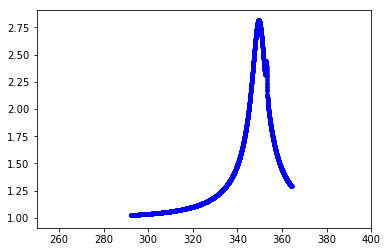

In [96]:
plt.plot(df['t'],df['f_true'],'b.')
plt.xlim(250,400)

In [97]:
fname = gzip.open(tempdata, 'rb')
x_0 = fname.readlines()[0:7]
f_s_true = x_0[0].split(' ')[4]
q = x_0[5].split(' ')[5]
s = x_0[5].split(' ')[6]
tE_theo = x_0[6].split(' ')[4]
t0_theo = x_0[6].split(' ')[3]
u0_theo = x_0[6].split(' ')[1]

In [98]:
A_max = 1.0/(float(f_s_true)/(max(df['f'])-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true =  df['t'][df['f'].argmax()] #float(t0_theo)
ind1, ind2 = fwhm(df['f'],df['f'].argmax(),min(df['f']))
#tE_true = t[ind2]-t[ind1]
tE_true = [tE_finder (df['t'],df[ 'f'], f_s_true),t[ind2]-t[ind1]]

In [99]:
tE_ = [[],[]]    
for i in tE_true:
               
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [t0_true, u0_true, i,f_s_true], args=(df['t'],df[ 'f'], df['f_err']),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml,f_s_ml = result['x']
    tE_[0].append(lnlike([t0_ml, u0_ml, tE_ml,f_s_ml],df['t'],df[ 'f'], df['f_err']))
    tE_[1].append([t0_ml, u0_ml, tE_ml,f_s_ml])

In [100]:
mm = np.asarray( tE_[0])
tE__ = tE_[1][mm.argmax()]

t0_ml, u0_ml, tE_ml,f_s_ml = tE__[0],tE__[1],tE__[2],tE__[3]

f_ris = df['f']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)
f_ris_true = df['f_true']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)


In [101]:
A_max = 1.0/(float(f_s_true)/(max(df['f']-f_ris)-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true = df['t'][(df['f']-f_ris).argmax()]

In [102]:
duration = [0.01,0.1,1]  

cut = 100
    
f_ris__ = [(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).max(),(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).min()]
t_ris__ =  [df['t'][(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).argmax()], df['t'][(f_ris[(df['t']>(float(t0_true)-cut))&(df['t']<(float(t0_true)+cut))]).argmin()]] 


In [103]:
f_ris__

[0.26973142504960057, -0.08577115480762876]

In [104]:
min_model_ = [[],[]]

for sigma in duration:
            
    for a in range(0,2):        
        amp_ = f_ris__[a]
        #print amp_
        t_mean_ = t_ris__[a]
        
        
        amp_ = amp_ * sigma * np.sqrt(2*pi)
        #print 'sigma = '+str(sigma) + ', amp = '+ str(amp_)
    
        nll = lambda *args: -lnlike2(*args)
        result = op.minimize(nll, [t_mean_,sigma,amp_,t0_ml, u0_ml, tE_ml,f_s_ml], args=(df['t'],df[ 'f'], df['f_err']),method = 'Nelder-Mead')
        mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll = result['x']
        #print result['x']
        min_model_[0].append(lnlike2([mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll],df['t'],df[ 'f'], df['f_err']))
        min_model_[1].append([mean_mll, sigma_mll,amp_mll,t0_mll, u0_mll, tE_mll,f_s_mll])


In [105]:
mmm_ = np.asarray( min_model_[0])
final_param = min_model_[1][mmm_.argmax()]       


In [106]:
final_param

[352.9417837982651,
 0.2270300073693184,
 1.0052131721146154,
 349.48055412953335,
 0.07060486451904241,
 44.85598217601512,
 0.13744989448879294]

In [107]:
A_max = 1.0/(float(f_s_true)/(max(df['f_true'])-1+float(f_s_true)))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true =  df['t'][df['f_true'].argmax()] #float(t0_theo)
ind1, ind2 = fwhm(df['f_true'],df['f_true'].argmax(),min(df['f_true']))
#tE_true = t[ind2]-t[ind1]
tE_true = [tE_finder (df['t'],df[ 'f_true'], f_s_true),t[ind2]-t[ind1]]

In [108]:
tE_ = [[],[]]    
for i in tE_true:
               
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [t0_true, u0_true, i,f_s_true], args=(df['t'],df[ 'f_true'], df['f_err']),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml,f_s_ml = result['x']
    tE_[0].append(lnlike([t0_ml, u0_ml, tE_ml,f_s_ml],df['t'],df[ 'f_true'], df['f_err']))
    tE_[1].append([t0_ml, u0_ml, tE_ml,f_s_ml])

In [109]:
mm = np.asarray( tE_[0])
tE__ = tE_[1][mm.argmax()]

t0_ml, u0_ml, tE_ml,f_s_ml = tE__[0],tE__[1],tE__[2],tE__[3]

#f_ris = df['f']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)
f_ris_true = df['f_true']-fun(t0_ml, u0_ml, tE_ml,f_s_ml)

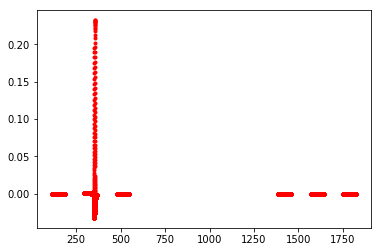

In [119]:
plt.plot(df['t'],f_ris_true,'r.')
#plt.xlim(492,496)

In [111]:
print df['t'][f_ris_true.argmax()], max(f_ris_true)
print df['t'][f_ris_true.argmin()], min(f_ris_true)

352.93386574 0.2319992931944137
351.91002315 -0.032403992718671226


(492, 496)

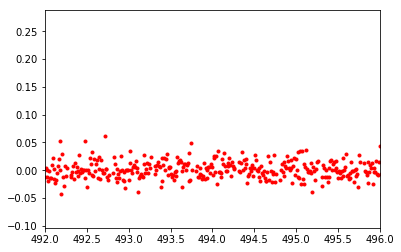

In [112]:
plt.plot(df['t'],f_ris,'r.')
plt.xlim(492,496)

In [123]:
def fun3 (mean, sigma,amp,f_s):
    A = (((amp/np.sqrt(2*pi*(sigma**2)))*np.exp(-((df['t']-mean)**2)/(2*(sigma**2)))))
    return (f_s * (A-1)) +1

def lnlike3(theta, t, f, f_err):
    mean, sigma,amp,f_s = theta
    model = fun3(mean, sigma,amp,f_s)
    inv_sigma2 = 1.0/(f_err**2)
    return (np.sum((f-model)**2*inv_sigma2))




In [125]:
min_model_ = [[],[]]

for sigma in duration:
            
            
    amp_ = max(f_ris_true)
    #print amp_        
    t_mean_ = df['t'][f_ris_true.argmax()]
        
        
    amp_ = amp_ * sigma * np.sqrt(2*pi)
    #print 'sigma = '+str(sigma) + ', amp = '+ str(amp_)
    
    nll = lambda *args: lnlike3(*args)
    result = op.minimize(nll, [t_mean_,sigma,amp_,f_s_ml], args=(df['t'],f_ris_true, df['f_err']),method = 'Nelder-Mead')
    mean_mll, sigma_mll,amp_mll,f_s_mll = result['x']
    #print result['x']
    min_model_[0].append(lnlike3([mean_mll, sigma_mll,amp_mll,f_s_mll],df['t'],f_ris_true, df['f_err']))
    min_model_[1].append([mean_mll, sigma_mll,amp_mll,f_s_mll])



In [126]:
mmm_ = np.asarray( min_model_[0])
final_param = min_model_[1][mmm_.argmax()]  

In [127]:
final_param

[689.7266971234592,
 -0.02739801817839874,
 -0.015731457942932747,
 0.9999557129292307]